# XAI Laboratory 01 - Tabular Methods

This notebook is a hands-on laboratory to explore explainable AI (XAI) techniques for tabular datasets.
We use the UCI Adult income dataset and an XGBoost classifier as a running example to demonstrate both local and global explanation methods.

Sections cover: local explainers (LIME, SHAP), instance-level plots (ICE), global dependence (PDP and ALE), permutation feature importance, and feature interaction using Friedman's H-statistic.
Each section includes code to compute the explanation, plots to visualise results, and short guidance on interpretation and caveats.

Run the notebook cells sequentially; start by installing the required packages and executing the data/model cells. The examples assume the model and dataset variables (e.g., `X`, `y`, `model`) are already available from earlier cells.


## Necessary packages


In [1]:
!uv pip install numpy==1.25.2 pandas==2.0.3 scikit-learn==1.2.2 shap==0.45.1 xgboost==1.7.5 matplotlib==3.7.1 scipy==1.10.1 lime==0.2.0.1
!uv pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

Using Python 3.11.5 environment at: C:\Users\peper\OneDrive - Universidad Pontificia Comillas\Documentos\IMAT\5\explicabilidad\p1-tabular-methods-pepert03\.venv
Resolved 32 packages in 20ms
Uninstalled 1 package in 17ms
Installed 1 package in 49ms
 ~ xgboost==1.7.5
Using Python 3.11.5 environment at: C:\Users\peper\OneDrive - Universidad Pontificia Comillas\Documentos\IMAT\5\explicabilidad\p1-tabular-methods-pepert03\.venv
   Updating https://github.com/MaximeJumelle/ALEPython.git (dev)
    Updated https://github.com/MaximeJumelle/ALEPython.git (286350ab674980a32270db2a0b5ccca1380312a7)
Resolved 20 packages in 1.28s
Audited 20 packages in 1ms


In [2]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
import xgboost
from sklearn.model_selection import train_test_split

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

c:\Users\peper\OneDrive - Universidad Pontificia Comillas\Documentos\IMAT\5\explicabilidad\p1-tabular-methods-pepert03\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Dataset**
We will use the classic [UCI adult income dataset](https://archive.ics.uci.edu/dataset/2/adult). This is a classification task to predict if people made over $50k in the 1990's.

In [3]:
# Load Data from shap library
X, y = shap.datasets.adult()

**Model**
We will train an XGBoost classifier model with default parameters for explanatory purposes. We are also performing a 50-50 train/test split for optimization purposes.

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train XGBoost model, may take a few minutes
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Local Explanations 🏘️

Table of Contents
* [LIME 🍋](https://colab.research.google.com/drive/1aBZSreILCbF3x7f5PIIlA3eNTmxoyzL7#scrollTo=nTO5RNakdVPW&line=19&uniqifier=1)
* [SHAP 🎲](https://colab.research.google.com/drive/1aBZSreILCbF3x7f5PIIlA3eNTmxoyzL7#scrollTo=kRWoDl1SdQbK&line=22&uniqifier=1)
* [ICE plots 🧊](https://colab.research.google.com/drive/1aBZSreILCbF3x7f5PIIlA3eNTmxoyzL7#scrollTo=8WVOuglNdgEJ&line=9&uniqifier=1)

## LIME 🍋

Local interpretable model-agnostic explanations (LIME) [[Paper, 2016]](https://arxiv.org/abs/1602.04938)

Interpretable models that are used to explain individual predictions of black box machine learning model

**LIME Process:**
1.   Select instance of interest
2.   Perturb your dataset and get black box predictions for perturbed samples
3.   Generate a new dataset consisting of perturbed samples (variations of your data) and the corresponding predictions
4.   Train an interpretable model, weighted by the proximity of sampled instances to the instance of interest
5.   Interpret the local model to explain prediction

As opposed to LIME for text, tabular explainers need a training set. This is because statistics are computed on each feature. If the feature is numerical, we compute the mean and std, and discretize it into quartiles. If the feature is categorical, we compute the frequency of each value. This is used to scale the data, so that we can meaningfully compute distances when the attributes are not on the same scale and to sample perturbed instances - which we do by sampling from a Normal(0,1), multiplying by the std and adding back the mean.


LIME uses an exponential smoothing kernel to define the neighborhood.
The kernel width determines how large the neighborhood is:
* Small kernel width = an instance must be very close to influence the local model
* Larger kernel width = instances that are farther away also influence the model

[LIME Code Tutorial from original paper authors](https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html)

For LIME, we need to define some information about the data

In [5]:
feature_names = ["Age", "Workclass",
                 "Education-Num", "Marital Status", "Occupation",
                 "Relationship", "Race", "Sex", "Capital Gain",
                 "Capital Loss", "Hours per week", "Country"]

categorical_features = ["Workclass", "Marital Status", "Occupation", "Relationship", "Race", "Sex", "Country"]

class_names = ['<=50K', '>50K']

categorical_names = {
    1: ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],  # Workclass
    3: ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],  # Marital Status
    4: ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],  # Occupation
    5: ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],  # Relationship
    6: ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],  # Race
    7: ['Female', 'Male'],  # Sex
    11: ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']  # Country
}

In [9]:
# Define kernel_width
kernel_width = 3

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values ,class_names=class_names, feature_names=feature_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names, kernel_width=kernel_width)
# Choose a sample for explanation
idx = 0

# Explain the prediction using LIME
exp = explainer.explain_instance(X_test.values[idx], model.predict_proba, num_features=12)

# Show the explanation
exp.show_in_notebook(show_table=True)

### How to Interpret

On the left, the prediction probability is shown. This sample was predicted to be <=50K (this individual in the dataset was predicted to make less than $50k)

For this sample, features that contributed to the prediction of <=50k are shown in blue (left) and features that contributed to a prediction of >50k are shown in orange (right).

The table on the right shows the actual value for each feature for this particular instance and the feature is highlighted with its contribution to each of the binary outcomes.

In [7]:
# Choose a sample for explanation
idx = 100

# Explain the prediction using LIME
exp = explainer.explain_instance(X_test.values[idx], model.predict_proba, num_features=12)

# Show the explanation
exp.show_in_notebook()

⚠️ Warning about using LIME for tabular data ⚠️

* Defining the neighborhood around a point is difficult and can change the results of your local model

* There is not yet a robust way to find the best kernel or width

---



## SHAP 🎲

SHapley Additive exPlanations [Paper, 2017](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)


Builds off of Shapley Values by approximating them.

* Shapley Values is a method from coalitional game theory (where game players cooperate in a coalition) that tells us how to fairly distribute “payout” to players depending on their contribution to the total payout [Paper, 1952](https://www.rand.org/content/dam/rand/pubs/papers/2021/P295.pdf)
* For our purposes, we will assume the prediction task is the “game”, each feature value of the instance is a “player”, and the prediction is the “payout”

The `shap` library has great [documentation](https://shap.readthedocs.io/en/latest/) with excellent tutorials.

**The role of the background distribution:**

* *Baseline Value Calculation*: SHAP values explain a prediction by comparing it to a baseline value, which is typically the average prediction over the background dataset. This baseline serves as a reference point to understand how much each feature contributes to the difference between the actual prediction and this average prediction. Below, you will see this variable as `X100`.

* *Expectation of Model Output*: When calculating SHAP values, the background dataset is used to estimate the expected value of the model's output. This expected value is the average prediction across the background dataset and represents what the model would predict in the absence of specific information about a given instance.

* *Marginal Contribution of Features*: SHAP values measure the marginal contribution of each feature to the prediction. This involves considering what the model would predict if each feature were missing or replaced by values from the background distribution. Essentially, SHAP values quantify how much each feature contributes to the difference between the actual prediction and the baseline value derived from the background dataset.

* *Sampling and Computational Efficiency*: Using a background dataset allows SHAP to approximate the impact of removing a feature by averaging over many possible values that the feature could take. This is more computationally efficient than considering all possible combinations of feature values.

...

Below, we implement the **TreeSHAP algorithm**.
You can read more about the TreeSHAP algorithm in the [Interpretable ML Book](https://christophm.github.io/interpretable-ml-book/shap.html#treeshap).

In [10]:
# Compute SHAP values
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

explainer = shap.TreeExplainer(model, X100) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test) # Get shap values
shap_values_exp = explainer(X_test) # Get explainer for X_test

 99%|===================| 16189/16281 [00:39<00:00]        

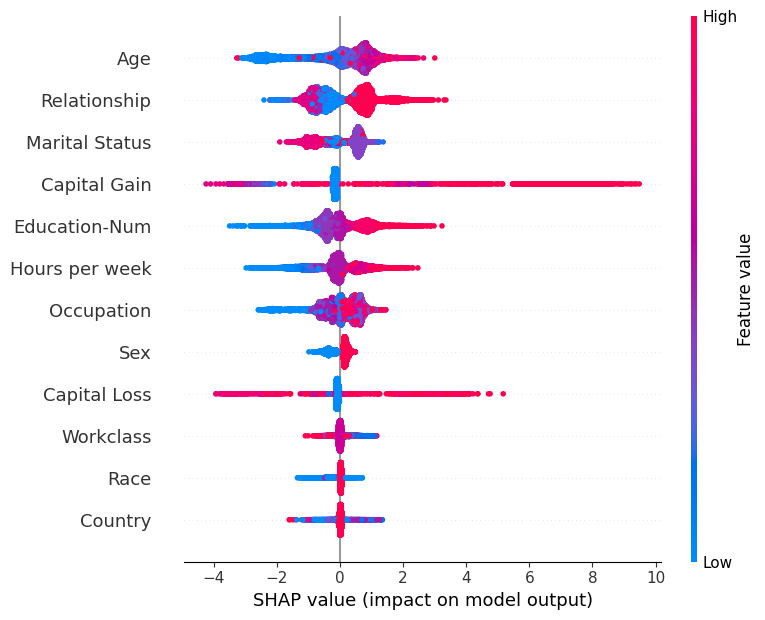

In [11]:
# Visualize SHAP with Summary Plot
shap.summary_plot(shap_values, X_test)

### How to Interpret - SHAP Summary Plot

The Summary Plot is a beeswarm plot. We can see the features listed on the left side of the plot. The bottom shows the SHAP value, which is the impact on the model output.

* For classification models, especially binary classifiers, a negative SHAP value indicates that the feature is contributing to lowering the probability of the positive class, or increasing the probability of the negative class, (<=50k).

* Postive SHAP values indicate that the feature is contributing to increasing the probability of the positive class (>50k)

* Whether the value of the feature is low or high is shown by the color, with low feature values in blue and high feature values shown in red. This is normalized by feature.

* Using the `plot_type="bar"` shows the importance of the input variables as the mean absolute value of the Shapley values of each input variable.

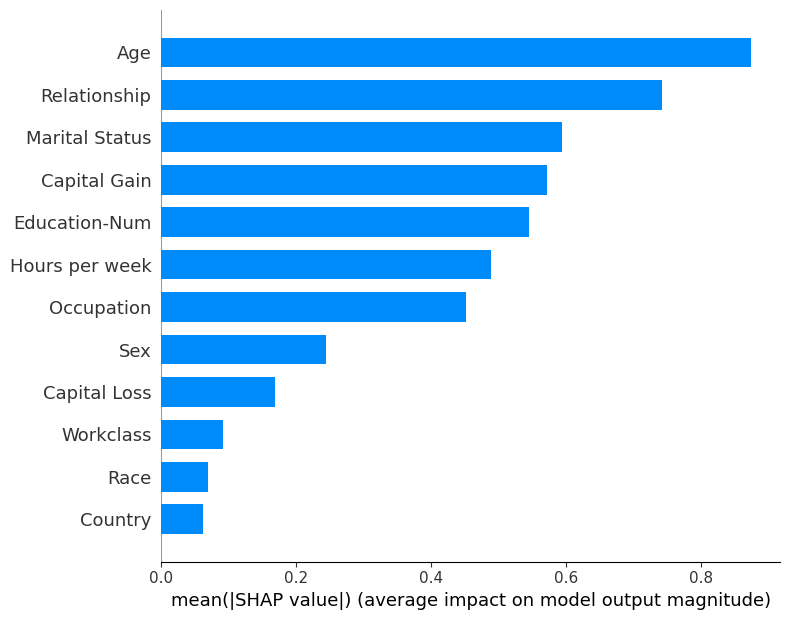

In [12]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## ICE Plots 🧊

Individual Conditional Expectation (ICE) plots one line per instance that displays how the instance’s prediction changes when a feature changes [Paper, 2014](https://arxiv.org/pdf/1309.6392)

**How it Works**
1. Select instance and feature of interest
2. Keep all other features the same, create variants of the instance by replacing the feature’s value with values from a grid
3. Make predictions with the black box model for newly created instances
4. You now have a set of points for an instance with the feature value from the grid and the respective predictions

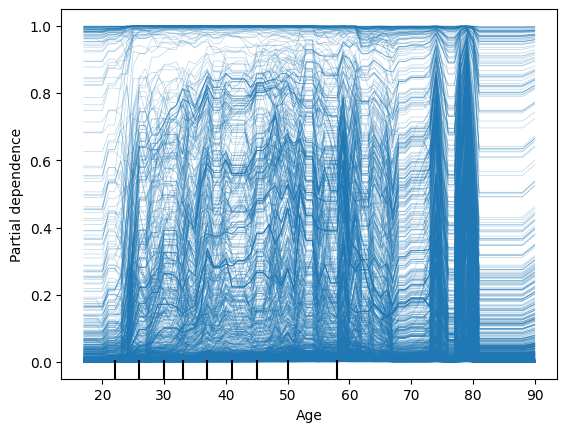

In [13]:
# Choose the feature of interest
features = ["Age"]

# Use PartialDependenceDisplay to display the ICE plot
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual') 

#### Centered ICE plots (c-ICE) ⚖️
We can center the curves at a certain point in the feature and display only the difference in the prediction to this point

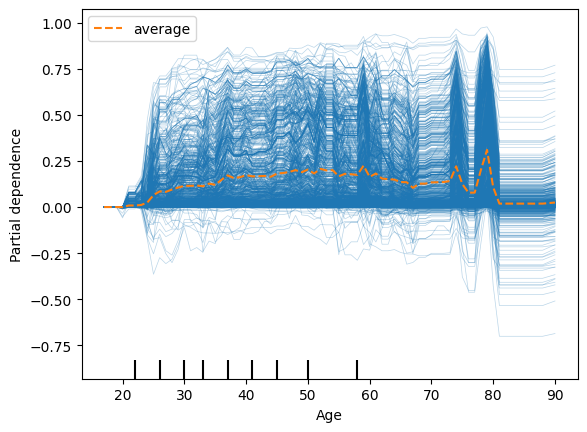

In [14]:
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', centered=True)

#### ICE Plot using numpy

We can also use numpy to compute ICE plots. Scikit-learn does not support looking at individual instances in their PartialDependenceDisplay, so if we want to look at individual instances rather than all of the instances, we will need to code the plots ourselves using numpy and matplotlib.

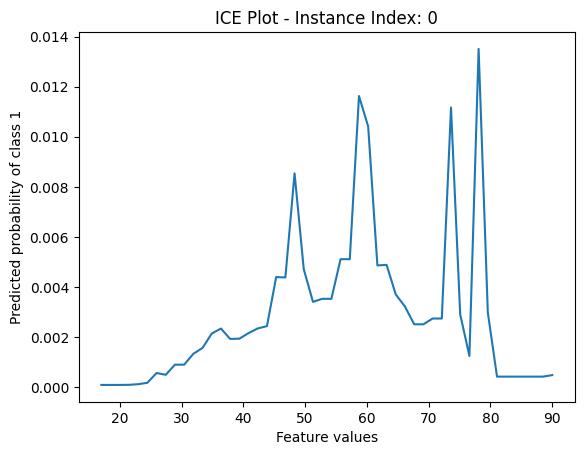

In [15]:
# Choose the instance and feature for which you want to plot the ICE plot
instance_index = 0  # Choose the index of the instance you want to visualize
feature_index = 0  # Let's look at "Age"

# Create feature grid
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=50)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Extract the instance of interest
instance = X.iloc[[instance_index]]

# Duplicate the instance to modify feature values
instance_modified = instance.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for the instance:
    instance_modified.iloc[:, feature_index] = value

    # Predict using the modified instance:
    prediction = model.predict_proba(instance_modified)[:, 1]

    # Store the prediction for the current feature value:
    average_predictions[i] = prediction.item()

# Plot the ICE plot
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature values')
plt.ylabel('Predicted probability of class 1')
plt.title(f'ICE Plot - Instance Index: {instance_index}')
plt.show()

#### How to Interpret - ICE Plot

For the instance demonstrated above, as age increases, the predicted probability of >=50k increases. There is interesting behavior around 80 years old for this instance.

Try another instance yourself to see how the ICE plot and interpretation changes across instances!

# Global Explanations 🌎

Table of Contents
* [Partial Dependence Plots](https://colab.research.google.com/drive/1WhBODDgVGE4NdnWtCouRuFn8rj0oxT6K#scrollTo=b9WMrsxrSc4Z&line=1&uniqifier=1)
* [ALE Plots](https://colab.research.google.com/drive/1WhBODDgVGE4NdnWtCouRuFn8rj0oxT6K#scrollTo=H4na5VBGOath&line=6&uniqifier=1)
* [Permutation Feature Importance](https://colab.research.google.com/drive/1WhBODDgVGE4NdnWtCouRuFn8rj0oxT6K#scrollTo=SLIGY1TLbSVm&line=21&uniqifier=1)
* [Feature Interaction](https://colab.research.google.com/drive/1WhBODDgVGE4NdnWtCouRuFn8rj0oxT6K#scrollTo=Fn1TE2O-aByw&line=6&uniqifier=1)

## Partial Dependence Plots (PDP) 📈

A Partial Dependence Plot (PDP or PD) shows the marginal effect one or two features have on the predicted outcome of a model [Paper, 2001](https://jerryfriedman.su.domains/ftp/trebst.pdf)

**How it Works:**
1. Select feature of interest
2. For every instance in training dataset:
* Keep all other features the same, create variants of the instance by replacing the feature’s value with values from a grid
* Make predictions with the black box model for newly created instances
* You now have a set of points for an instance with the feature value from the grid and the respective predictions
3. Average across all instances and plot

Here we will show both a built-in library implementation, [scikit learn's Partial Dependence Display](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.PartialDependenceDisplay.html) and we will build our own implementation in numpy.


#### Using PartialDependenceDisplay

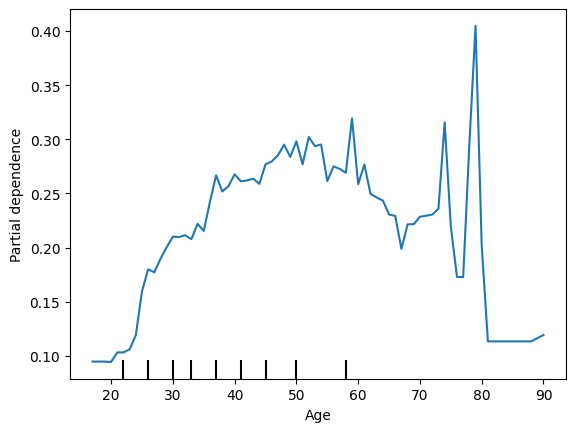

In [16]:
# Choose the feature of interest
features = ["Age"]

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average') #kind='both' if you also want the ICE plots

#### Build our own PDP with numpy

When we build our own, you will notice we build our own grid of values and can change the size of our grid.

This is why you may see slight variations between the PDP created with numpy versus the PartialDependenceDisplay from scikit learn.

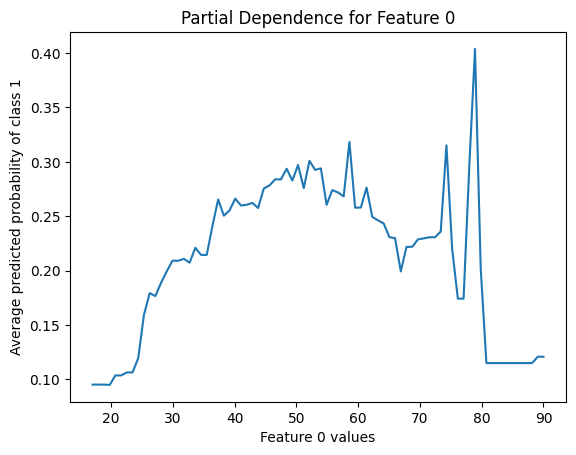

In [17]:
# Choose the feature for which you want to plot partial dependence
feature_index = 0  # For example, the first feature

# Create feature grid - here is where you can update the size of the grid by updating num
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=80)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Duplicate the dataset to modify feature values
X_modified = X.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for all instances
    X_modified.iloc[:, feature_index] = value

    # Predict using the modified dataset
    predictions = model.predict_proba(X_modified)[:, 1]

    # Calculate average prediction for the current feature value
    average_predictions[i] = np.mean(predictions)

# Plot the partial dependence for the chosen feature
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature {feature_index} values')
plt.ylabel('Average predicted probability of class 1')
plt.title(f'Partial Dependence for Feature {feature_index}')
plt.show()

When we build our own PDP, we can run interesting experiments, like the one below, where we can see the impact of changing the size of our grid.

#### How to Interpret

* Look at the shape of the curve on the plot. Is it linear, non-linear, or does it have any particular pattern? This gives you insights into how the feature affects the prediction.

* Determine whether increasing or decreasing values of the feature variable lead to higher or lower predictions. Does the curve slope upwards, downwards, or remain relatively flat?

* Note whether the curve reaches a plateau or has any upper or lower limits. This indicates whether there's a point beyond which changing the feature variable has little effect on the prediction.

* Consider how the observed relationships align with your understanding of the problem domain. Are the results intuitive? Do they make sense based on what you know about the data?


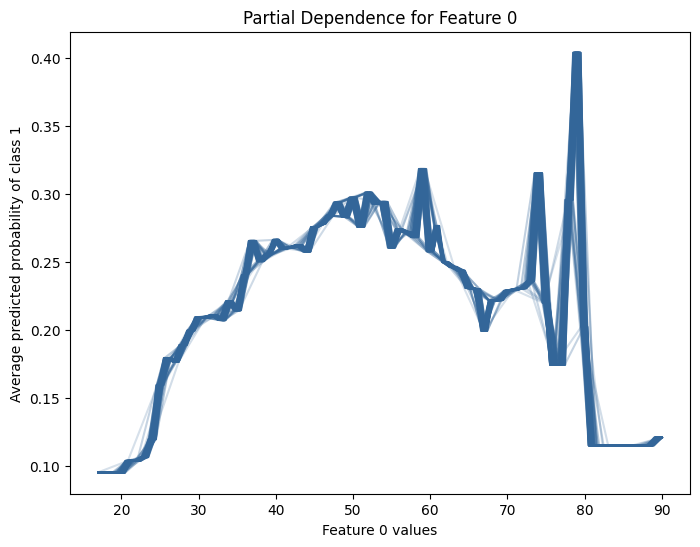

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

grid_length = np.linspace(20, 120, 40)
fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and axis for plotting

# Define a base color and alpha (transparency) values
base_color = (0.2, 0.4, 0.6)  # Blue-ish color
min_alpha = 0.2
max_alpha = 1.0

# Normalize grid_length values between 0 and 1
normalized_g = (grid_length - grid_length.min()) / (grid_length.max() - grid_length.min())

for i, g in enumerate(grid_length):
    # Create feature grid
    feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=int(g))
    # Initialize array to store average predictions
    average_predictions = np.zeros_like(feature_values)
    # Duplicate the dataset to modify feature values
    X_modified = X.copy()
    # Loop over feature values
    for j, value in enumerate(feature_values):
        # Set the chosen feature to the current value for all instances
        X_modified.iloc[:, feature_index] = value
        # Predict using the modified dataset
        predictions = model.predict_proba(X_modified)[:, 1]
        # Calculate average prediction for the current feature value
        average_predictions[j] = np.mean(predictions)
    # Calculate color based on normalized g
    alpha = min_alpha + (max_alpha - min_alpha) * normalized_g[i]
    color = to_rgba(base_color, alpha)
    # Plot the partial dependence for the chosen feature
    ax.plot(feature_values, average_predictions, color=color)

ax.set_xlabel(f'Feature {feature_index} values')
ax.set_ylabel('Average predicted probability of class 1')
ax.set_title(f'Partial Dependence for Feature {feature_index}')
plt.show()

## ALE Plots 📉

Accumulated Local Effects (ALE) Plots [Paper, 2020](https://www.scholars.northwestern.edu/en/publications/visualizing-the-effects-of-predictor-variables-in-black-box-super)

**How to create an ALE plot:**
1. Bin the Feature: Divide the feature of interest into several intervals (bins). These bins help in managing the data and computing local effects within smaller, more manageable segments.
2. Compute Local Effects: For each bin, calculate the local effect of the feature on the prediction. This involves: Calculating the change in prediction when moving from the lower to the upper edge of the bin
Averaging this change over all instances that fall into that bin
3. Accumulate Effects: Starting from the first bin, accumulate the local effects across all bins. Sum up the average effects sequentially to show how the feature influences the prediction as its value changes
4. Centering: To make the plot more interpretable, center the accumulated effects around zero. Subtract the mean of the accumulated effects, which forces the interpretation to focus on deviations from the average prediction

There are a few python implementations of ALE plots, here we show the [ALEPython implementation](https://github.com/blent-ai/ALEPython).

The implementation is more complex and less intuitive than PDPs, with many hyperparameters, including:
* **bins** - This parameter defines the number of bins to divide the range of the specified feature into. A larger number of bins can provide more granularity in the ALE plot but might also increase computation time.
* **monte_carlo** - This parameter is a boolean flag indicating whether to use Monte Carlo sampling to estimate the ALE. Monte Carlo sampling can be beneficial when the number of samples in the dataset is large, as it reduces computational burden.
* **monte_carlo_rep** - This parameter specifies the number of Monte Carlo replicates to use for estimating the ALE. More replicates can lead to a more accurate estimation but may also increase computation time.
* **monte_carlo_ratio** - This parameter determines the proportion of the dataset to use for Monte Carlo sampling. It's a value between 0 and 1, where 1 means using the entire dataset. Using a smaller ratio can speed up computation but may introduce some sampling error.


This can take a couple of minutes to run:

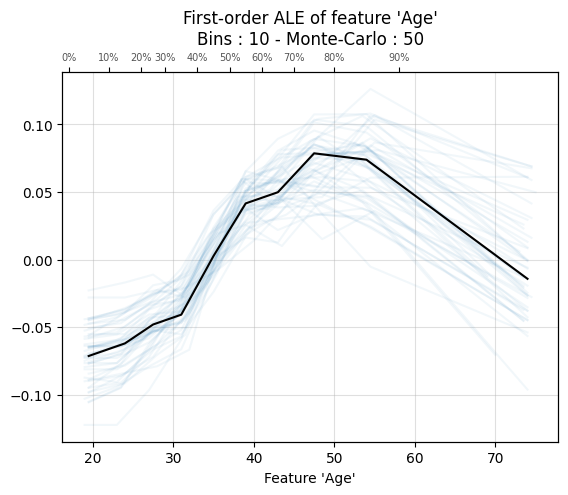

<Axes: title={'center': "First-order ALE of feature 'Age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'Age'">

In [19]:
# Use default parameters for 1D Main Effect ALE Plot
ale_plot(model, X_train, 'Age', monte_carlo=True)

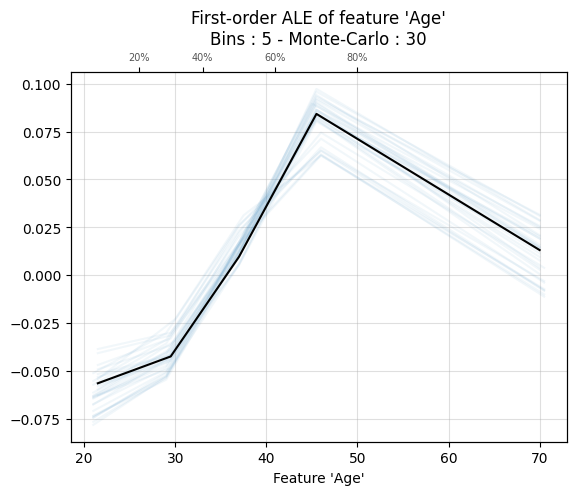

<Axes: title={'center': "First-order ALE of feature 'Age'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'Age'">

In [20]:
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "Age",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

#### How to Interpret 1D Main Effect ALE Plot



* X-axis represents feature values
* Y-axis shows average effect on predictions
* Each curve represents a feature's ALE. - Flat curves imply little impact; steep curves, significant impact
* Upward curves: increasing feature value increases predictions; downward, the opposite
* Steeper curves signify larger effects

We can compare ALE plots to gauge relative feature importance.
Features with steeper curves have larger impacts.

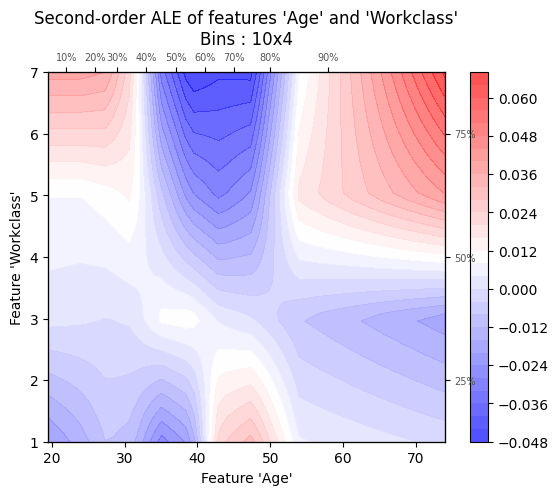

<Axes: title={'center': "Second-order ALE of features 'Age' and 'Workclass'\nBins : 10x4"}, xlabel="Feature 'Age'", ylabel="Feature 'Workclass'">

In [21]:
# 2D Second-Order ALE Plot
ale_plot(model, X_train, X_train.columns[:2], bins=10)

#### How to Interpret - 2D Second-Order ALE Plot

* Both axes represent the values of the two features being analyzed.
* Each axis corresponds to one of the features.
* The plot displays a surface where the height represents the average effect on predictions. Higher points indicate regions where the model tends to make higher predictions, and vice versa.
* Patterns in the surface reveal how the joint behavior of the two features affects the model's predictions. Peaks or valleys suggest regions where the joint effect is particularly strong.
* The direction of the slope indicates whether increasing one feature while holding the other constant tends to increase or decrease predictions. Steeper slopes represent larger effects, while flatter regions indicate smaller effects.


We can compare the 2D Second-Order ALE Plot with individual ALE plots for each feature to understand how joint effects differ from marginal effects.

## Permutation Feature Importance

The importance of a feature can be measured by calculating how much model’s prediction error increases after permuting the feature.
* If shuffling a feature’s values increases the model error, the feature is important
* If the model error doesn’t change after shuffling a feature’s values, a feature is considered unimportant

First introduced for random forests [Paper, 2001](https://link.springer.com/article/10.1023/A:1010933404324). Updated to be model agnostic - renamed “model reliance” [Paper, 2018](https://arxiv.org/abs/1801.01489).

**Process for Model Agnostic measure:**
1. Input: Trained model 𝑓^, feature matrix 𝑋, target vector 𝑦, error measure 𝐿(𝑦,𝑓^).
2. Estimate the original model error 𝑒𝑜𝑟𝑖𝑔=𝐿(𝑦,𝑓^(𝑋)) (e.g. mean squared error)
3. For each feature 𝑗∈{1,...,𝑝}:
* Generate feature matrix 𝑋𝑝𝑒𝑟𝑚 by permuting feature j in the data X. This breaks the association between feature j and true outcome y
* Estimate error 𝑒𝑝𝑒𝑟𝑚=𝐿(𝑌,𝑓^(𝑋𝑝𝑒𝑟𝑚)) based on the predictions of the permuted data.
* Calculate permutation feature importance as quotient 𝐹𝐼𝑗=𝑒𝑝𝑒𝑟𝑚/𝑒𝑜𝑟𝑖𝑔 or difference 𝐹𝐼𝑗=𝑒𝑝𝑒𝑟𝑚 - 𝑒𝑜𝑟𝑖𝑔
4. Sort features by descending FI

**Implementation in Python**
Here we will demonstrate the implementation in the scikit-learn library.[[Documentation Here](https://scikit-learn.org/stable/modules/permutation_importance.html)]

The scikit-learn implementation of the permutation_importance function calculates the feature importance of estimators for a given dataset. The n_repeats parameter sets the number of times a feature is randomly shuffled and returns a sample of feature importances.

* n_repeats - number of times to permute a feature



In [22]:
# Compute permutation importances
perm_imp = permutation_importance(model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [23]:
# Print the mean and standard deviation of permutation importances for each feature

for i in perm_imp.importances_mean.argsort()[::-1]:
    if perm_imp.importances_mean[i] - 2 * perm_imp.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
              f"{perm_imp.importances_mean[i]:.3f}"
              f" +/- {perm_imp.importances_std[i]:.3f}")

Capital Gain0.050 +/- 0.001
Relationship0.036 +/- 0.002
Education-Num0.031 +/- 0.002
Occupation0.018 +/- 0.002
Age     0.018 +/- 0.002
Capital Loss0.012 +/- 0.001
Hours per week0.009 +/- 0.001
Marital Status0.007 +/- 0.001
Workclass0.005 +/- 0.001


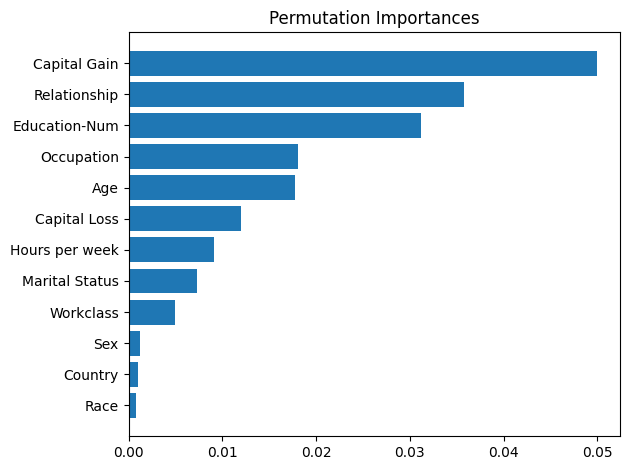

In [24]:
# Plot Permutation Feature Importances as a bar chart
sorted_idx = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], perm_imp.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

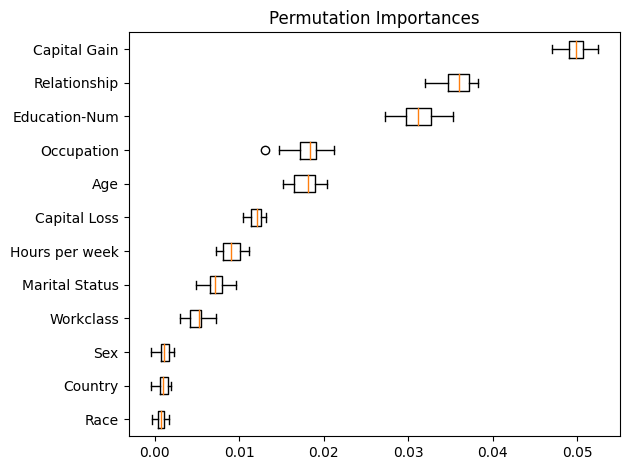

In [25]:
# Plot Permutation Feature Importances as a box plot

fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

⚠️ Caution when using Permutation Feature Importance ⚠️

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. [Source](https://scikit-learn.org/stable/modules/permutation_importance.html#id2)

## Feature Interaction — Friedman H statistic

We compute Friedman's H-statistic to quantify the interaction strength between pairs of features.
We restrict pairwise computations to numeric features for robustness (grid-based averaging on observed values).

The implementation below:
- approximates the partial dependence on a grid for pairs and single features,
- computes H^2 = E[(f_ij - f_i - f_j + f0)^2] / Var(f(X)) and reports H = sqrt(H^2),
- displays a heatmap of pairwise H, and lists the top interacting pairs.


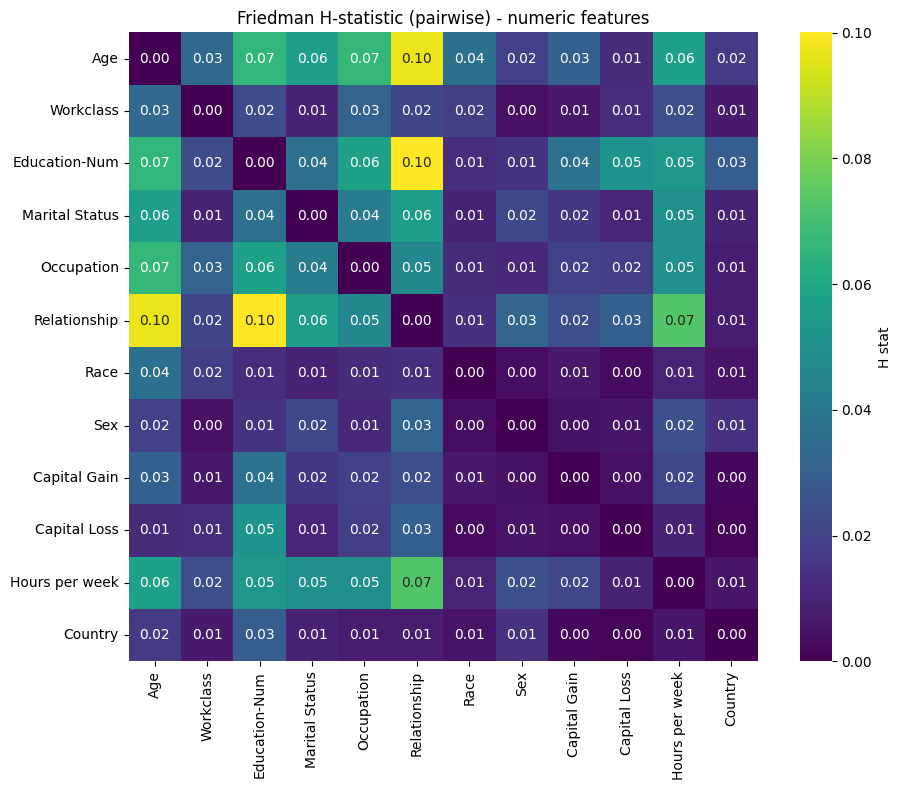

Top interacting pairs (feature_a, feature_b, H):
Education-Num        Relationship         0.1001
Age                  Relationship         0.0970
Relationship         Hours per week       0.0727
Age                  Occupation           0.0665
Age                  Education-Num        0.0657
Education-Num        Occupation           0.0569
Age                  Hours per week       0.0565
Age                  Marital Status       0.0555
Marital Status       Relationship         0.0552
Education-Num        Hours per week       0.0532


In [27]:
# Friedman H-statistic (pairwise) - approximate grid-based implementation
def friedman_h_pair(model, X, feat_a, feat_b, grid_resolution=10):
    # predict probabilities for the positive class and baseline
    preds = model.predict_proba(X)[:, 1]
    f0 = preds.mean()
    denom = np.mean((preds - f0) ** 2)  # Var(f(X)) around mean
    if denom == 0:
        return 0.0

    # Build grids using quantiles (robust to distribution)
    vals_a = np.quantile(X[feat_a], np.linspace(0, 1, grid_resolution))
    vals_b = np.quantile(X[feat_b], np.linspace(0, 1, grid_resolution))

    # Evaluate f_ij on the grid (mean over other features)
    f_ij = np.zeros((len(vals_a), len(vals_b)))
    for i, va in enumerate(vals_a):
        for j, vb in enumerate(vals_b):
            X_temp = X.copy()
            X_temp[feat_a] = va
            X_temp[feat_b] = vb
            f_ij[i, j] = model.predict_proba(X_temp)[:, 1].mean()

    # Evaluate main effects on their grids
    f_i = np.zeros(len(vals_a))
    for i, va in enumerate(vals_a):
        X_temp = X.copy(); X_temp[feat_a] = va
        f_i[i] = model.predict_proba(X_temp)[:, 1].mean()

    f_j = np.zeros(len(vals_b))
    for j, vb in enumerate(vals_b):
        X_temp = X.copy(); X_temp[feat_b] = vb
        f_j[j] = model.predict_proba(X_temp)[:, 1].mean()

    # Map each instance to nearest grid cell (by absolute distance)
    a_vals = X[feat_a].values
    b_vals = X[feat_b].values
    idx_a = np.abs(a_vals[:, None] - vals_a[None, :]).argmin(axis=1)
    idx_b = np.abs(b_vals[:, None] - vals_b[None, :]).argmin(axis=1)

    f_ij_at = f_ij[idx_a, idx_b]
    f_i_at = f_i[idx_a]
    f_j_at = f_j[idx_b]

    diff = f_ij_at - f_i_at - f_j_at + f0
    num = np.mean(diff ** 2)
    h2 = num / denom if denom > 0 else 0.0
    return float(np.sqrt(max(0.0, h2)))

# Compute pairwise H for numeric features only (safer for grid-based approach)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
n = len(numeric_cols)
H_mat = np.zeros((n, n))

import itertools

for i, j in itertools.combinations(range(n), 2):
    a = numeric_cols[i]
    b = numeric_cols[j]
    h = friedman_h_pair(model, X, a, b, grid_resolution=10)
    H_mat[i, j] = H_mat[j, i] = h

# Create a DataFrame for easier display
H_df = pd.DataFrame(H_mat, index=numeric_cols, columns=numeric_cols)

# Show heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(H_df, annot=True, fmt='.2f', cmap='viridis', square=True, cbar_kws={'label': 'H stat'})
plt.title('Friedman H-statistic (pairwise) - numeric features')
plt.tight_layout()
plt.show()

# Print top interacting pairs
pairs = []
for i in range(n):
    for j in range(i + 1, n):
        pairs.append((numeric_cols[i], numeric_cols[j], H_mat[i, j]))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)
print('Top interacting pairs (feature_a, feature_b, H):')
for a, b, h in pairs_sorted[:10]:
    print(f'{a:<20} {b:<20} {h:.4f}')


### How to interpret the Friedman H-statistic

- The H-statistic measures the fraction of the model output variance that is attributable to interaction between the two features (for pairwise H). Practically, H is the square-root of that fraction, so H in [0, 1].
- H ≈ 0: little to no interaction — the joint effect of the two features is well explained by the sum of their individual (main) effects.
- H closer to 1: strong interaction — a large portion of the model's variance comes from the joint behaviour of the two features (their combined effect cannot be decomposed into independent main effects).
- Compare H across pairs: higher H indicates stronger interaction relative to other pairs, but absolute values depend on model output scale and baseline variance; use rankings rather than single-number thresholds when in doubt.
- Caveats and practical tips:
  - Our implementation uses grid-based averages (quantile grids) and numeric features; results depend on grid_resolution and the grid strategy. Increase resolution for more accurate estimates (at higher computational cost).
  - For categorical features, evaluate over observed categories rather than numeric quantiles (not implemented above).
  - H is model- and data-dependent: different models or different background datasets can change H values. Always compute H using the dataset of interest (e.g., training or validation set).
  - Small sample sizes, uneven distributions, or coarse grids can produce noisy H estimates — treat small differences with caution.

Use the heatmap and the printed top pairs to identify candidate interacting features, then inspect 2D PDPs, ALE surfaces, or conditional dependence plots for those pairs to understand the interaction shape and domain regions where it matters.